In [20]:
period=-2400
time_interval='1d'
tickers = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X']
forex_tickers = ['EURUSD', 'GBPUSD', 'USDCHF', 'USDJPY']


%run forex_data_loader.ipynb

yfinance version: 0.2.50
Start load FOREX data interval with: 1d, from: 2018-05-07 18:27:07.148508


[*********************100%***********************]  4 of 4 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1715 entries, 2018-05-07 to 2024-12-01
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (USDJPY=X, Open)       1715 non-null   float64
 1   (USDJPY=X, High)       1715 non-null   float64
 2   (USDJPY=X, Low)        1715 non-null   float64
 3   (USDJPY=X, Close)      1715 non-null   float64
 4   (USDJPY=X, Adj Close)  1715 non-null   float64
 5   (USDJPY=X, Volume)     1715 non-null   int64  
 6   (EURUSD=X, Open)       1714 non-null   float64
 7   (EURUSD=X, High)       1714 non-null   float64
 8   (EURUSD=X, Low)        1714 non-null   float64
 9   (EURUSD=X, Close)      1714 non-null   float64
 10  (EURUSD=X, Adj Close)  1714 non-null   float64
 11  (EURUSD=X, Volume)     1714 non-null   float64
 12  (GBPUSD=X, Open)       1714 non-null   float64
 13  (GBPUSD=X, High)       1714 non-null   float64
 14  (GBPUSD=X, Low)        1714 non-null  

In [8]:
import talib as ta
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import backtesting
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

In [22]:
%run file_loader.ipynb
%run useful_functions.ipynb

In [23]:
forex_tickers = ['EURUSD', 'GBPUSD', 'USDCHF', 'USDJPY']
dir = "forex_data"
forex_dfs = []
for name in forex_tickers:
    f = os.path.join(dir, name+'.csv')
    if os.path.isfile(f):
        df = loading_v3(f)
        
        df = add_signal(df)
        df = add_pointpos_column(df, "Signal")

        df = df.sort_values('Date').reset_index(drop=True)
        df = df.set_index('Date')

        forex_dfs.append(df)


ValueError: Missing column provided to 'parse_dates': 'Date'

In [11]:
sum([frame["Signal"].value_counts() for frame in forex_dfs], start=0)

Signal
0    6823
1      18
2      16
Name: count, dtype: int64

In [12]:
plot_candlestick_with_signals(forex_dfs[0], start_index=300, num_rows=355) #EURUSD

In [13]:
from backtesting import Backtest, Strategy

def SIGNAL():
    return df.Signal

class Strategy01(Strategy):
    trade_size = 0.1  # Trade size
    slperc = 0.04
    tpperc = 0.02

    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)  # Assuming SIGNAL is a function that returns signals

    def next(self):
        super().next()

        if self.signal1 == 2 and not self.position:
            # Open a new long position with calculated SL and TP
            current_close = self.data.Close[-1]
            sl = current_close - self.slperc * current_close  # SL at 4% below the close price
            tp = current_close + self.tpperc * current_close  # TP at 2% above the close price
            self.buy(size=self.trade_size, sl=sl, tp=tp)

        elif self.signal1 == 1 and not self.position:
            # Open a new short position, setting SL based on a strategy-specific requirement
            current_close = self.data.Close[-1]
            sl = current_close + self.slperc * current_close  # SL at 4% below the close price
            tp = current_close - self.tpperc * current_close  # TP at 2% above the close price
            self.sell(size=self.trade_size, sl=sl, tp=tp)

In [14]:
results = []

for df in forex_dfs:
    bt = Backtest(df, Strategy01, cash=5000, margin=1/5, commission=0.0002)
    stats, heatmap = bt.optimize(slperc=[i/100 for i in range(1, 8)],
                                tpperc=[i/100 for i in range(1, 8)],
                                maximize='Return [%]', max_tries=3000,
                                random_state=0,
                                return_heatmap=True)
    results.append(stats)

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

Backtest.optimize:   0%|          | 0/9 [00:00<?, ?it/s]

In [15]:
agg_returns = sum([r["Return [%]"] for r in results])
num_trades = sum([r["# Trades"] for r in results])
max_drawdown = min([r["Max. Drawdown [%]"] for r in results])
avg_drawdown = sum([r["Avg. Drawdown [%]"] for r in results]) / len(results)

win_rate = sum([r["Win Rate [%]"] for r in results]) / len(results)
best_trade = max([r["Best Trade [%]"] for r in results])
worst_trade = min([r["Worst Trade [%]"] for r in results])
avg_trade = sum([r["Avg. Trade [%]"] for r in results]) / len(results)
max_trade_duration = max([r["Max. Trade Duration"] for r in results])
# avg_trade_duration = sum([r["Avg. Trade Duration"] for r in results]) / len(results)

print(f"Aggregated Returns: {agg_returns:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Average Drawdown: {avg_drawdown:.2f}%")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Best Trade: {best_trade:.2f}%")
print(f"Worst Trade: {worst_trade:.2f}%")
print(f"Average Trade: {avg_trade:.2f}%")
print(f"Maximum Trade Duration: {max_trade_duration} days")
# print(f"Average Trade Duration: {avg_trade_duration:.2f} days")


Aggregated Returns: 34.77%
Number of Trades: 18
Maximum Drawdown: -6.07%
Average Drawdown: -0.73%
Win Rate: 85.83%
Best Trade: 7.39%
Worst Trade: -7.16%
Average Trade: 4.25%
Maximum Trade Duration: 672 days 00:00:00 days


In [16]:
equity_curves = [stats['_equity_curve']['Equity'] for stats in results]
max_length = max(len(equity) for equity in equity_curves)

# Pad each equity curve with the last value to match the maximum length
padded_equity_curves = []
for equity in equity_curves:
    last_value = equity.iloc[-1]
    padding = [last_value] * (max_length - len(equity))
    padded_equity = equity.tolist() + padding
    padded_equity_curves.append(padded_equity)

equity_df = pd.DataFrame(padded_equity_curves).T

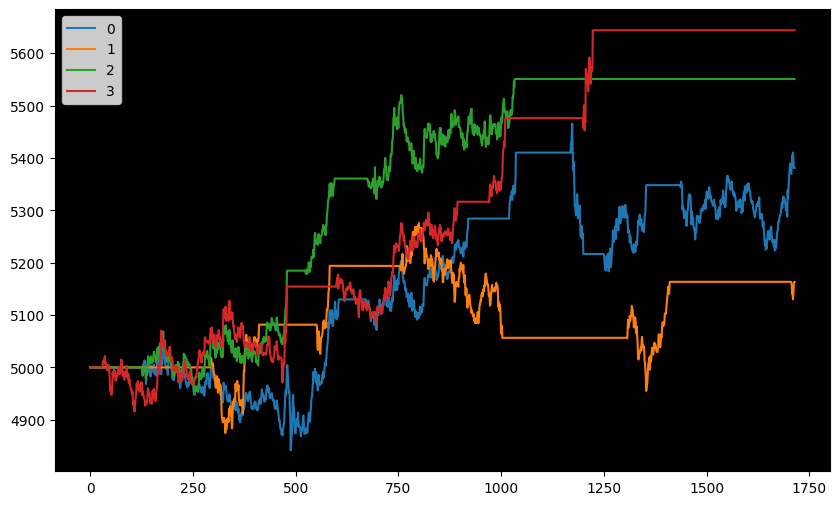

In [17]:
equity_df.plot(kind='line', figsize=(10, 6), legend=True).set_facecolor('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')
plt.gca().set_facecolor('black')

In [18]:
[r["Return [%]"] for r in results]

[7.615131876489886, 3.265204542469983, 11.013573050755513, 12.873588561737051]

In [19]:
results[0] # EURUSD
# results[1] # GBPUSD
# results[2] # EURUSD
# results[3] # EURUSD

Start                     2018-05-07 00:00:00
End                       2024-11-29 00:00:00
Duration                   2398 days 00:00:00
Exposure Time [%]                   67.794632
Equity Final [$]                  5380.756594
Equity Peak [$]                   5465.373502
Return [%]                           7.615132
Buy & Hold Return [%]                -11.6436
Return (Ann.) [%]                    1.084871
Volatility (Ann.) [%]                2.759339
Sharpe Ratio                         0.393163
Sortino Ratio                        0.567197
Calmar Ratio                         0.210357
Max. Drawdown [%]                   -5.157296
Avg. Drawdown [%]                   -0.768347
Max. Drawdown Duration      756 days 00:00:00
Avg. Drawdown Duration       64 days 00:00:00
# Trades                                    6
Win Rate [%]                        83.333333
Best Trade [%]                       6.017794
Worst Trade [%]                     -7.159025
Avg. Trade [%]                    